In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import sys
import pandas as pd

import pickle
import glob


In [11]:
root = "/checkpoint/yuandong"

def get_loss_and_corr(stats,max_epoch):
#     print(len(stats["data"]))
#     print(stats["args"])
#     print()
    stats = stats["data"]
    losses = np.array([s["eval_loss"] for s in stats])
    acces = np.array([s["eval_accuracy"] for s in stats])
    max_epoch = len(stats) if max_epoch is None else max_epoch
    
    corrs = np.zeros((4, max_epoch))
    for layer in range(4):
        for i in range(max_epoch):
            s = stats[i]
            sorted_corrs = s["eval_corrs"][layer].sort(0)[0]
            max_corrs = sorted_corrs[-1,:]
            corrs[layer, i] = max_corrs.mean().item()
    return losses, corrs, acces
        
def get_grouped_info(save_dir,add_accuracy=False,save_name=None,*,lower=0.4, max_epoch=None):
    files = [f for f in glob.glob(save_dir + "*.pickle", recursive=True)]
    all_losses = []
    all_corrs = []
    all_acc = []
    for filename in files:
        file_path = os.path.join(save_dir, filename)
        stats = pickle.load(open(os.path.join(file_path), "rb"))
        print('max_epoch=', max_epoch)
        loss, corr, acc = get_loss_and_corr(stats, max_epoch)
        all_losses.append(loss)
        all_corrs.append(corr)
        all_acc.append(acc)

    all_losses = np.array(all_losses)
    all_corrs = np.array(all_corrs)
    all_acc = np.array(all_acc)
    loss_mean = all_losses.mean(axis=0)
    loss_min = all_losses.min(axis=0)
    loss_max = all_losses.max(axis=0)

    corr_mean = all_corrs.mean(axis=0)
    corr_min = all_corrs.min(axis=0)
    corr_max = all_corrs.max(axis=0)
    
    acc_mean = all_acc.mean(axis=0)
    acc_min = all_acc.min(axis=0)
    acc_max = all_acc.max(axis=0)
    
    n_layer, n_epoch = corr_mean.shape
        
    
    if add_accuracy:
        fig = plt.figure(figsize=(8.2, 2.5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = ax1.twinx()
        ax1.plot(range(n_epoch), loss_mean, 'C0')
        ax1.fill_between(range(n_epoch), loss_min, loss_max,alpha=0.2, color='C0')
        ax2.plot(range(n_epoch), acc_mean, 'C1')
        ax1.set_ylabel('Loss in Evaluation',color='C0')
        ax2.set_ylabel('Accuracy in Evaluation',color='C1')
        ax2.fill_between(range(n_epoch), acc_min, acc_max,alpha=0.2, color='C1')
        ax1.set_xlabel('Epoch')
    else:
        plt.figure(figsize=(8.2, 2.5))
        n_image = 2 
        plt.subplot(1, n_image, 1)
        plt.plot(loss_mean)
        plt.fill_between(range(n_epoch), loss_min, loss_max,alpha=0.2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss in Evaluation')
    

    plt.subplot(1, 2, 2)
    for layer in range(n_layer):
        plt.plot(corr_mean[layer], label=f"layer-{layer}")
        plt.fill_between(range(n_epoch), corr_min[layer], corr_max[layer],alpha=0.2)

    plt.axis([0, n_epoch, lower, 1.01])
    plt.xlabel('Epoch')
    plt.ylabel('Normalized Corr')
    plt.legend()
    plt.subplots_adjust(wspace=0.5)


    if save_name:
        plt.tight_layout()
        plt.savefig(save_name)
    else:
        plt.show()
    plt.close()
    print('done')
    return loss_mean, loss_min, loss_max, corr_mean, corr_min, corr_max, acc_mean, acc_min, acc_max

def get_mean_median_top(stats, n_it=5, n_layer=4):
#     print(len(stats["data"]))
#     print(stats["args"])
#     print()
    stats = stats["data"]
    mean_top_percents = np.zeros((n_it, n_layer))
    median_top_percents = np.zeros((n_it, n_layer))

    for baseline_it in range(n_it):
        for layer in range(n_layer):
            init_sorted_indices = stats[baseline_it]["eval_corrs"][layer].sort(0, descending=True)[1]
            n_student_node, n_teacher_node = init_sorted_indices.size()

            # Make an index map. 
            init_index_map = np.zeros((n_student_node, n_teacher_node))
            for i in range(n_teacher_node):
                init_index_map[init_sorted_indices[:,i],i] = range(n_student_node)

            # Final state. 
            final_sorted_indices = stats[-1]["eval_corrs"][layer].sort(0, descending=True)[1]

            # Average rank:
            ranks = np.zeros(n_teacher_node)
            for i in range(n_teacher_node):
                ranks[i] = init_index_map[final_sorted_indices[0, i], i]

            mean_top_percent = np.mean(ranks)/n_student_node*100
            median_top_percent = np.median(ranks)/n_student_node*100

            # print(f"Layer-{layer}: mean top-rank: {mean_top_percent:#02f}%, median top-rank: {median_top_percent:#02f}%")
            mean_top_percents[baseline_it, layer] = mean_top_percent
            median_top_percents[baseline_it, layer] = median_top_percent
    return mean_top_percents, median_top_percents

def get_mean_min_max(xs):
    xs = np.array(xs)
    x_mean = xs.mean(axis=0)
    x_min = xs.min(axis=0)
    x_max = xs.max(axis=0)
    return x_mean, x_min,  x_max

def get_rank_mean_median_plot(save_dir,save_name=None,*,n_it=5):
    files = [f for f in glob.glob(save_dir + "*.pickle", recursive=True)]
    all_mean = []
    all_median = []
    for filename in files:
        file_path = os.path.join(save_dir, filename)
        stats = pickle.load(open(os.path.join(file_path), "rb"))
        mean_top_percents, median_top_percents = get_mean_median_top(stats, n_it=n_it)
        all_mean.append(mean_top_percents)
        all_median.append(median_top_percents)

    mean_mean, mean_min, mean_max = get_mean_min_max(all_mean)
    median_mean, median_min, median_max = get_mean_min_max(all_median)
    n_epoch, n_layer = mean_mean.shape
    plt.figure(figsize=(7.5, 2.6))
    plt.subplot(1,2,1)
    for layer in range(n_layer):
        plt.plot(mean_mean[:,layer], label=f'layer-{layer}')
        plt.fill_between(range(n_epoch), mean_min[:,layer], mean_max[:, layer],alpha=0.2)
    
    plt.axis([0, n_it, 0, 50])
    plt.title('Mean Rank of final winner of students')
    plt.ylabel('Top-% of student nodes')
    plt.xticks(range(n_it))
    plt.xlabel('Epoch (0=initialization)')
    plt.legend()

    plt.subplot(1,2,2)
    for layer in range(n_layer):
        plt.plot(median_mean[:,layer], label=f'layer-{layer}')
        plt.fill_between(range(n_epoch), median_min[:,layer], median_max[:, layer],alpha=0.2)
    plt.axis([0, n_it, 0, 50])
    plt.title('Median Rank of final winner of students')
    plt.ylabel('Top-% of student nodes')
    plt.xticks(range(n_it))
    plt.xlabel('Epoch (0=initialization)')
    plt.legend()
    
    plt.subplots_adjust(wspace=0.5)

    if save_name:
        plt.tight_layout()
        plt.savefig(save_name)
    else:
        plt.show()
        
    
    plt.close()

    return mean_mean, mean_min, mean_max, median_mean, median_min, median_max

In [23]:
def plot_cor_and_mean_rank(save_dir,save_name=None,*,n_it=5,lower=0.4,max_epoch=None):
    files = [f for f in glob.glob(os.path.join(save_dir, "*.pickle"), recursive=True)]
    if len(files) == 0:
        print(f"No pickle file under {save_dir}")
        return
    all_mean = []
    all_corrs = []
    for filename in files:
        file_path = os.path.join(save_dir, filename)
        stats = pickle.load(open(file_path, "rb"))
        mean_top_percents, median_top_percents = get_mean_median_top(stats, n_it=n_it)
        all_mean.append(mean_top_percents)
        _, corr, _ = get_loss_and_corr(stats, max_epoch=max_epoch)
        all_corrs.append(corr)
    
    corr_mean, corr_min, corr_max = get_mean_min_max(all_corrs)
    mean_mean, mean_min, mean_max = get_mean_min_max(all_mean)
    
    
    
    plt.figure(figsize=(7.5, 2.6))
    n_layer, n_epoch = corr_mean.shape
    plt.subplot(1, 2, 1)
    for layer in range(n_layer):
        plt.plot(corr_mean[layer], label=f"layer-{layer}")
        plt.fill_between(range(n_epoch), corr_min[layer], corr_max[layer],alpha=0.2)

    plt.axis([0, n_epoch, lower, 1.01])
    plt.xlabel('Epoch')
    plt.ylabel('Normalized Corr')
    plt.legend()
    
    
    n_epoch, n_layer = mean_mean.shape
    plt.subplot(1,2,2)
    for layer in range(n_layer):
        plt.plot(mean_mean[:,layer], label=f'layer-{layer}')
        plt.fill_between(range(n_epoch), mean_min[:,layer], mean_max[:, layer],alpha=0.2)
    
    plt.axis([0, n_it-1, 0, 50])
#     plt.title('Mean Rank of final winner of students')
    plt.ylabel('Top-% of student nodes')
    plt.xticks(range(n_it))
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplots_adjust(wspace=0.5)

    if save_name:
        plt.tight_layout()
        plt.savefig(save_name)
    else:
        plt.show()
        
    
    plt.close()
    print('done')
    

        
    

In [24]:
save_dir = os.path.join(root, 'data/cifar10_fc_has_bn')
save_name= os.path.join(root, 'plots/cifar10_fc_has_bn.pdf')
m = plot_cor_and_mean_rank(save_dir,None,lower=0,n_it=10,max_epoch=40)

No pickle file under /checkpoint/yuandong/data/cifar10_fc_has_bn


In [17]:
def plot_cor_mean(exp_name,need_acc=False,lower=0.4,max_epoch=40):
    save_dir = "/checkpoint/tinayujiang/temp/dl_threory_Hs/for_paper/" + exp_name
    save_name= os.path.join(root, exp_name + '.pdf')
    m = plot_cor_and_mean_rank(save_dir,save_name,lower=lower,max_epoch=max_epoch,n_it=10)


In [25]:
plot_cor_mean('gaussian_cnn_has_bn_regen',lower=0,max_epoch=40)
plot_cor_mean('gaussian_fc_has_bn_regen',max_epoch=40)
plot_cor_mean('gaussian_cnn_no_bn_regen',lower=0,max_epoch=40)
plot_cor_mean('gaussian_fc_no_bn_regen',max_epoch=40)


plot_cor_mean('gaussian_cnn_has_bn_no_sep_init_regen',lower=0)
plot_cor_mean('gaussian_cnn_no_bn',lower=0)
plot_cor_mean('gaussian_cnn_no_bn_no_sep_init_regen',lower=0)
plot_cor_mean('gaussian_fc_has_bn_no_sep_init_regen')
plot_cor_mean('gaussian_fc_no_bn_no_sep_init_regen')
plot_cor_mean('gaussian_fc_has_bn')
plot_cor_mean('gaussian_fc_no_bn')
plot_cor_mean('gaussian_small_has_bn')
plot_cor_mean('gaussian_small_no_bn')


done
done
done
done
done
done
done
done
done
done
done
done
done


In [26]:
plot_cor_mean('gaussian_cnn_has_bn',lower=0)

done


In [6]:
def plot_cor_mean_100(exp_name,need_acc=False,lower=0.4,max_epoch=100):
    save_dir = '/checkpoint/tinayujiang/temp/dl_threory_Hs/0524/'+exp_name+'/'
    save_name='/checkpoint/tinayujiang/temp/dl_threory_Hs/notebook_plots_0523_100/'+ exp_name +'.pdf'
    m = plot_cor_and_mean_rank(save_dir,save_name,lower=lower,max_epoch=max_epoch,n_it=10)


In [139]:
plot_cor_mean_100('cifar10_cnn_has_bn',lower=0)
plot_cor_mean_100('cifar10_fc_has_bn')
plot_cor_mean_100('gaussian_cnn_has_bn_regen',lower=0)
plot_cor_mean_100('gaussian_fc_has_bn_regen')

plot_cor_mean_100('cifar10_cnn_no_bn',lower=0)
plot_cor_mean_100('cifar10_fc_no_bn')
plot_cor_mean_100('gaussian_cnn_no_bn_regen',lower=0)
plot_cor_mean_100('gaussian_fc_no_bn_regen')


done
done
done
done
done
done
done
done


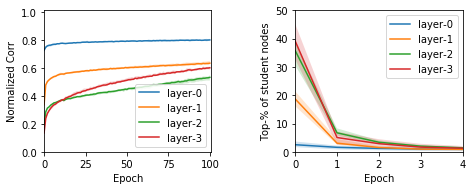

done


In [136]:
save_dir = '/checkpoint/tinayujiang/temp/dl_threory_Hs/0524/cifar10_cnn_has_bn/'
save_name='/private/home/tinayujiang/repo/dl_theory2/notebook_plots/cifar10_fc_has_bn.pdf'
m = plot_cor_and_mean_rank(save_dir,None,lower=0)

max_epoch= None
max_epoch= None
max_epoch= None
max_epoch= None
max_epoch= None


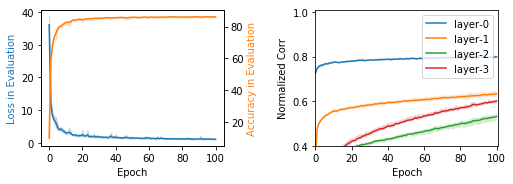

done


In [137]:
cifar10_fc_bn = '/checkpoint/tinayujiang/temp/dl_threory_Hs/0524/cifar10_cnn_has_bn/'
x = '/private/home/tinayujiang/repo/dl_theory2/notebook_plots/cifar10_fc_has_bn.pdf'
m = get_grouped_info(cifar10_fc_bn,True,None)

In [170]:

cifar10_fc_no_bn = '/checkpoint/tinayujiang/temp/dl_threory_Hs/cifar10_fc_no_bn/'
m = get_grouped_info(cifar10_fc_no_bn,True,'/private/home/tinayujiang/repo/dl_theory2/notebook_plots/cifar10_fc_no_bn.pdf')

In [171]:
gaussian_has_bn = '/checkpoint/tinayujiang/temp/dl_threory_Hs/0520/gaussian_has_bn_no_teacher_bn/'
m = get_grouped_info(gaussian_has_bn,False,'/private/home/tinayujiang/repo/dl_theory2/notebook_plots/gaussian_has_bn.pdf')

In [172]:
gaussian_has_bn_regen = '/checkpoint/tinayujiang/temp/dl_threory_Hs/0520/gaussian_has_bn_no_teacher_bn_regen/'
m = get_grouped_info(gaussian_has_bn_regen,False,'/private/home/tinayujiang/repo/dl_theory2/notebook_plots/gaussian_has_bn_regen.pdf')

In [175]:
gaussian_no_bn_2 = '/checkpoint/tinayujiang/temp/dl_threory_Hs/0520/gaussian_no_bn/'
m = get_grouped_info(gaussian_no_bn_2,False, '/private/home/tinayujiang/repo/dl_theory2/notebook_plots/gaussian_no_bn.pdf')



In [176]:

save_dir = '/checkpoint/tinayujiang/temp/dl_threory_Hs/0520/gaussian_no_bn_regen/'
m = get_grouped_info(save_dir,False,'/private/home/tinayujiang/repo/dl_theory2/notebook_plots/gaussian_no_bn_regen.pdf' )

In [ ]:
plt.

In [7]:
def get_mean_median_top(stats, n_it=5, n_layer=4):
#     print(len(stats["data"]))
#     print(stats["args"])
#     print()
    stats = stats["data"]
    mean_top_percents = np.zeros((n_it, n_layer))
    median_top_percents = np.zeros((n_it, n_layer))

    for baseline_it in range(n_it):
        for layer in range(n_layer):
            init_sorted_indices = stats[baseline_it]["eval_corrs"][layer].sort(0, descending=True)[1]
            n_student_node, n_teacher_node = init_sorted_indices.size()

            # Make an index map. 
            init_index_map = np.zeros((n_student_node, n_teacher_node))
            for i in range(n_teacher_node):
                init_index_map[init_sorted_indices[:,i],i] = range(n_student_node)

            # Final state. 
            final_sorted_indices = stats[-1]["eval_corrs"][layer].sort(0, descending=True)[1]

            # Average rank:
            ranks = np.zeros(n_teacher_node)
            for i in range(n_teacher_node):
                ranks[i] = init_index_map[final_sorted_indices[0, i], i]

            mean_top_percent = np.mean(ranks)/n_student_node*100
            median_top_percent = np.median(ranks)/n_student_node*100

            # print(f"Layer-{layer}: mean top-rank: {mean_top_percent:#02f}%, median top-rank: {median_top_percent:#02f}%")
            mean_top_percents[baseline_it, layer] = mean_top_percent
            median_top_percents[baseline_it, layer] = median_top_percent
    return mean_top_percents, median_top_percents

def get_mean_min_max(xs):
    xs = np.array(xs)
    x_mean = xs.mean(axis=0)
    x_min = xs.min(axis=0)
    x_max = xs.max(axis=0)
    return x_mean, x_min, x_max

def get_rank_mean_median_plot(save_dir,save_name=None,*,n_it=5):
    files = [f for f in glob.glob(save_dir + "*.pickle", recursive=True)]
    all_mean = []
    all_median = []
    for filename in files:
        file_path = os.path.join(save_dir, filename)
        stats = pickle.load(open(os.path.join(file_path), "rb"))
        mean_top_percents, median_top_percents = get_mean_median_top(stats, n_it=n_it)
        all_mean.append(mean_top_percents)
        all_median.append(median_top_percents)

    mean_mean, mean_min, mean_max = get_mean_min_max(all_mean)
    median_mean, median_min, median_max = get_mean_min_max(all_median)
    n_epoch, n_layer = mean_mean.shape
    plt.figure(figsize=(7.5, 2.6))
    plt.subplot(1,2,1)
    for layer in range(n_layer):
        plt.plot(mean_mean[:,layer], label=f'layer-{layer}')
        plt.fill_between(range(n_epoch), mean_min[:,layer], mean_max[:, layer],alpha=0.2)
    
    plt.axis([0, n_it, 0, 50])
    plt.title('Mean Rank of final winner of students')
    plt.ylabel('Top-% of student nodes')
    plt.xticks(range(n_it))
    plt.xlabel('Epoch (0=initialization)')
    plt.legend()

    plt.subplot(1,2,2)
    for layer in range(n_layer):
        plt.plot(median_mean[:,layer], label=f'layer-{layer}')
        plt.fill_between(range(n_epoch), median_min[:,layer], median_max[:, layer],alpha=0.2)
    plt.axis([0, n_it, 0, 50])
    plt.title('Median Rank of final winner of students')
    plt.ylabel('Top-% of student nodes')
    plt.xticks(range(n_it))
    plt.xlabel('Epoch (0=initialization)')
    plt.legend()
    
    plt.subplots_adjust(wspace=0.5)

    if save_name:
        plt.tight_layout()
        plt.savefig(save_name)
    else:
        plt.show()
        
    
    plt.close()

    return mean_mean, mean_min, mean_max, median_mean, median_min, median_max

In [103]:
plt.show()

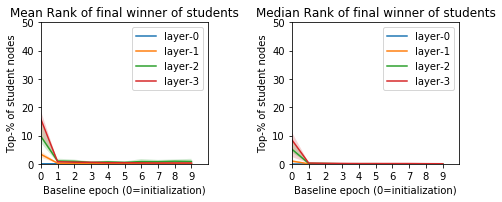

In [113]:

save_dir='/checkpoint/tinayujiang/temp/dl_threory_Hs/0521/gaussian_cnn_has_bn/'
save_name='/private/home/tinayujiang/repo/dl_theory2/notebook_plots/gaussian_no_bn_rank.pdf'
m = get_rank_mean_median_plot(save_dir,None,n_it=10)


In [196]:
save_dir='/checkpoint/tinayujiang/temp/dl_threory_Hs/0520/gaussian_no_bn_regen/'
save_name='/private/home/tinayujiang/repo/dl_theory2/notebook_plots/gaussian_no_bn_regen_rank.pdf'
m = get_rank_mean_median_plot(save_dir,save_name,n_it=10)



In [197]:
save_dir='/checkpoint/tinayujiang/temp/dl_threory_Hs/0520/gaussian_has_bn_no_teacher_bn/'
save_name='/private/home/tinayujiang/repo/dl_theory2/notebook_plots/gaussian_has_bn_rank.pdf'
m = get_rank_mean_median_plot(save_dir,save_name,n_it=10)


In [198]:
save_dir='/checkpoint/tinayujiang/temp/dl_threory_Hs/0520/gaussian_has_bn_no_teacher_bn_regen/'
save_name='/private/home/tinayujiang/repo/dl_theory2/notebook_plots/gaussian_has_bn_regen_rank.pdf'
m = get_rank_mean_median_plot(save_dir,save_name,n_it=10)


In [199]:
save_dir='/checkpoint/tinayujiang/temp/dl_threory_Hs/cifar10_fc_no_bn/'
save_name='/private/home/tinayujiang/repo/dl_theory2/notebook_plots/cifar10_fc_no_bn_rank.pdf'
m = get_rank_mean_median_plot(save_dir,save_name,n_it=10)


save_dir='/checkpoint/tinayujiang/temp/dl_threory_Hs/cifar10_fc_has_bn_2/'
save_name='/private/home/tinayujiang/repo/dl_theory2/notebook_plots/cifar10_fc_has_bn_rank.pdf'
m = get_rank_mean_median_plot(save_dir,save_name,n_it=10)


In [200]:
plt.show()

In [251]:
save_dir='/checkpoint/tinayujiang/temp/dl_threory_Hs/0521/gaussian_cnn_has_bn_lr_regen/'
save_name='/private/home/tinayujiang/repo/dl_theory2/notebook_plots/gaussian_cnn_has_bn_lr_regen_rank.pdf'
m = get_rank_mean_median_plot(save_dir,save_name,n_it=10)


In [250]:
save_dir = '/checkpoint/tinayujiang/temp/dl_threory_Hs/0521/gaussian_cnn_has_bn_lr_regen/'
save_name='/private/home/tinayujiang/repo/dl_theory2/notebook_plots/gaussian_cnn_has_bn_regen.pdf'
m = get_grouped_info(save_dir,False,save_name)

done


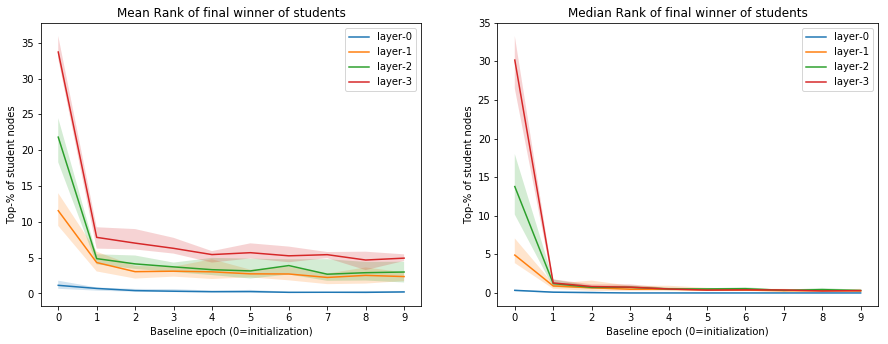

Namespace(batchsize=64, bn=True, bn_affine=True, bn_before_relu=False, cross_entropy=False, d_output=0, data_d=20, data_std=10.0, dataset='gaussian', eval_batchsize=64, init_multi=4, json_output=False, ks=[50, 75, 100, 125], load_teacher=None, lr={0: 0.1}, momentum=0.0, no_bias=False, no_sep_init=True, node_multi=10, normalize=False, num_epoch=40, num_iter=30000, num_trial=5, perturb=None, regen_dataset_each_epoch=False, same_dir=False, same_sign=False, save_dir='/checkpoint/tinayujiang/temp/dl_threory_Hs/0521/gaussian_has_bn_no_sep_lr', seed=8334, signature='052119_214828_886937', stats_H=False, stats_w=False, teacher_bn=False, teacher_bn_affine=False, use_cnn=False, weight_decay=0)
Namespace(batchsize=64, bn=True, bn_affine=True, bn_before_relu=False, cross_entropy=False, d_output=0, data_d=20, data_std=10.0, dataset='gaussian', eval_batchsize=64, init_multi=4, json_output=False, ks=[50, 75, 100, 125], load_teacher=None, lr={0: 0.1}, momentum=0.0, no_bias=False, no_sep_init=True, nod

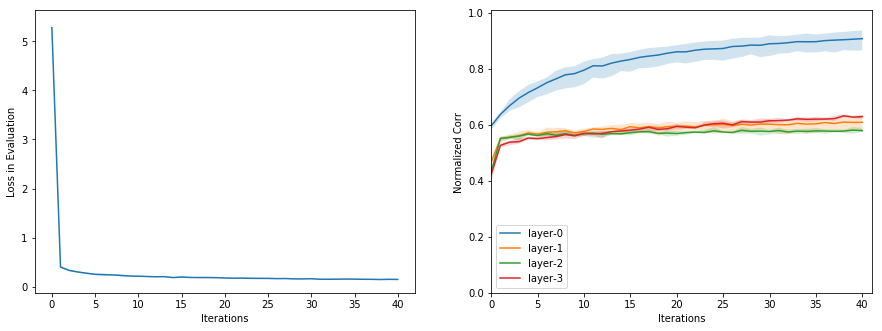

In [248]:


save_dir='/checkpoint/tinayujiang/temp/dl_threory_Hs/0521/gaussian_has_bn_no_sep_lr/'
save_name='/private/home/tinayujiang/repo/dl_theory2/notebook_plots/gaussian_cnn_has_bn_lr_regen_rank.pdf'
m = get_rank_mean_median_plot(save_dir,None,n_it=10)

save_dir = '/checkpoint/tinayujiang/temp/dl_threory_Hs/0521/gaussian_has_bn_no_sep_lr/'
save_name='/private/home/tinayujiang/repo/dl_theory2/notebook_plots/gaussian_cnn_has_bn_regen.pdf'
m = get_grouped_info(save_dir,False,None)

In [236]:
len(tmps) 
tmp2 = [float(x) for x in tmps]

In [240]:
plt.plot(np.arange(600)*200, tmp2)
plt.savefig('/checkpoint/tinayujiang/bridge/traning_0513_no_collab_eps_0_01_5.pdf')

In [234]:
tmps[0:10]

[' -0.4940416676513851\n',
 ' -0.22254166728630662\n',
 ' -0.17800000066682697\n',
 ' -0.10645833344385028\n',
 ' -0.08487500050291419\n',
 ' -0.06500000032037496\n',
 ' -0.06425000005960464\n',
 ' -0.05945833363756538\n',
 ' -0.05316666699945927\n',
 ' -0.01625000012665987\n']

In [235]:
float(tmps[0])

-0.4940416676513851

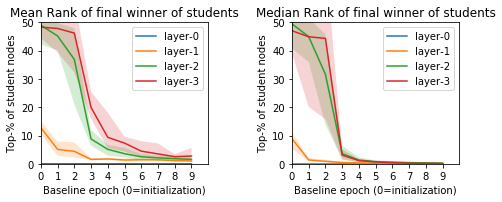

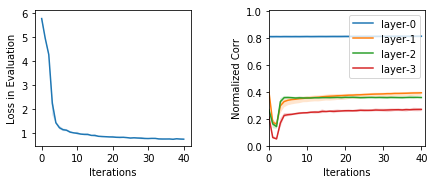

done


In [119]:
save_dir='/checkpoint/tinayujiang/temp/dl_threory_Hs/0521/gaussian_cnn_no_bn/'
save_name='/private/home/tinayujiang/repo/dl_theory2/notebook_plots/gaussian_cnn_has_bn_lr_regen_rank.pdf'
m = get_rank_mean_median_plot(save_dir,None,n_it=10)

save_dir = '/checkpoint/tinayujiang/temp/dl_threory_Hs/0521/gaussian_cnn_no_bn/'
save_name='/private/home/tinayujiang/repo/dl_theory2/notebook_plots/gaussian_cnn_has_bn_regen.pdf'
m = get_grouped_info(save_dir,False,None,lower=0)

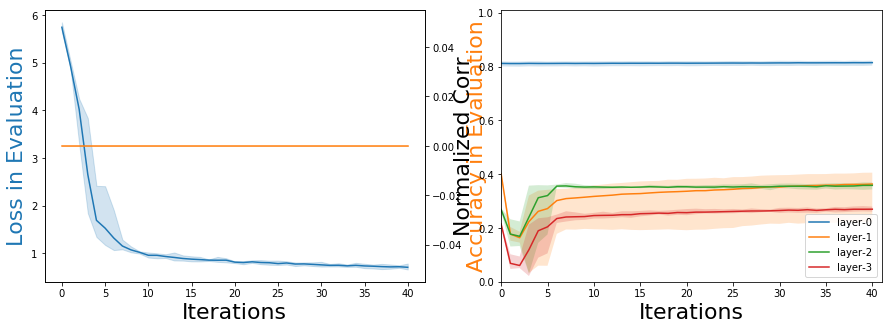

done


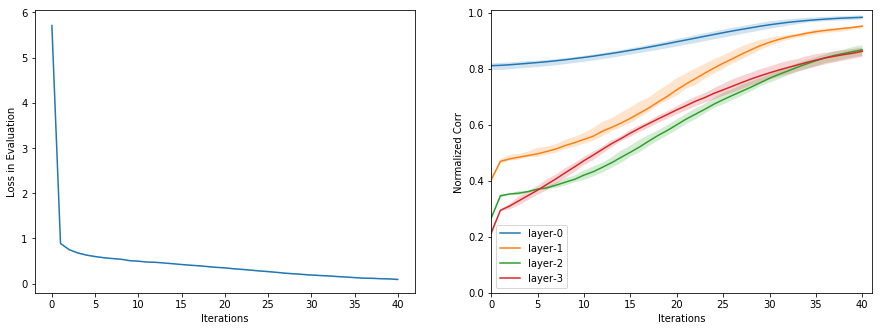

done


In [53]:
save_dir = '/checkpoint/tinayujiang/temp/dl_threory_Hs/0522/gaussian_cnn_has_bn_regen/'
save_name='/private/home/tinayujiang/repo/dl_theory2/notebook_plots/gaussian_cnn_has_bn_regen.pdf'
m = get_grouped_info(save_dir,False,None,lower=0)

In [49]:
save_dir = '/checkpoint/tinayujiang/temp/dl_threory_Hs/0522/gaussian_cnn_no_bn_regen_lr_0_01/'
save_name='/private/home/tinayujiang/repo/dl_theory2/notebook_plots/gaussian_cnn_no_bn_regen.pdf'
m = get_grouped_info(save_dir,False,save_name,lower=0)

done


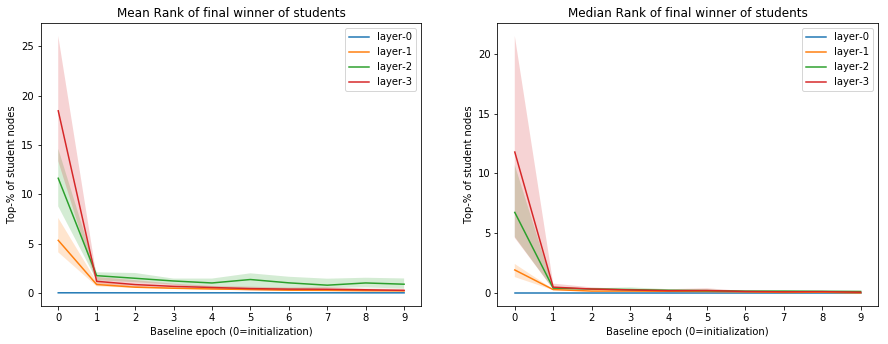

In [40]:
save_dir='/checkpoint/tinayujiang/temp/dl_threory_Hs/0522/gaussian_cnn_no_bn_regen_lr_0_01/'
save_name='/private/home/tinayujiang/repo/dl_theory2/notebook_plots/cifar10_fc_no_bn' +'_rank.pdf'
m = get_rank_mean_median_plot(save_dir,None,n_it=10)

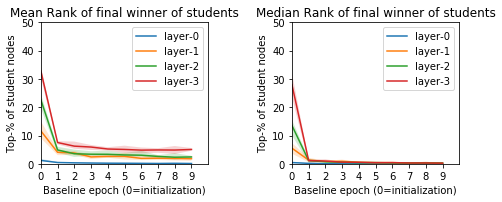

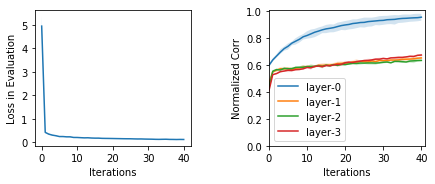

done


In [124]:
save_dir='/checkpoint/tinayujiang/temp/dl_threory_Hs/0522/gaussian_fc_has_bn_no_sep_init_regen/'
m = get_rank_mean_median_plot(save_dir,None,n_it=10)
m = get_grouped_info(save_dir,False,False,lower=0)

In [8]:
# get scripts ready for 100 epoches
def plot_corr_infor(exp_name,need_acc=False,lower=0.4):
    save_dir = '/checkpoint/tinayujiang/temp/dl_threory_Hs/0523/'+exp_name+'/'
    save_name='/checkpoint/tinayujiang/temp/dl_threory_Hs/notebook_plots/'+ exp_name +'.pdf'
    m = get_grouped_info(save_dir,need_acc,None,lower=lower)

def plot_rank(exp_name,n_it=10):
    save_dir='/checkpoint/tinayujiang/temp/dl_threory_Hs/0523/'+ exp_name + '/'
    save_name='/checkpoint/tinayujiang/temp/dl_threory_Hs/notebook_plots/'+ exp_name +'_rank.pdf'
    m = get_rank_mean_median_plot(save_dir,None,n_it=10)


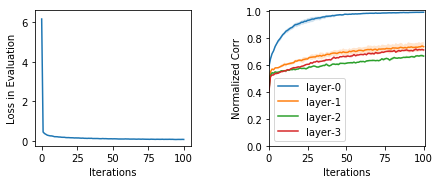

done


In [ ]:
plot_corr_infor('gaussian_fc_has_bn_regen',lower=0)
plot_rank('gaussian_fc_has_bn_regen')


In [75]:
# get scripts ready for 100 epoches
def plot_corr_infor(exp_name,need_acc=False,lower=0.4):
    save_dir = '/checkpoint/tinayujiang/temp/dl_threory_Hs/0524_2/'+exp_name+'/'
    save_name='/checkpoint/tinayujiang/temp/dl_threory_Hs/notebook_plots_5/'+ exp_name +'.pdf'
    m = get_grouped_info(save_dir,need_acc,save_name,lower=lower)

def plot_rank(exp_name,n_it=10):
    save_dir='/checkpoint/tinayujiang/temp/dl_threory_Hs/0524_2/'+ exp_name + '/'
    save_name='/checkpoint/tinayujiang/temp/dl_threory_Hs/notebook_plots_5/'+ exp_name +'_rank.pdf'
    m = get_rank_mean_median_plot(save_dir,save_name,n_it=10)


In [76]:
plot_corr_infor('cifar10_cnn_no_bn',True,lower=0)
plot_rank('cifar10_cnn_no_bn')


max_epoch= None
max_epoch= None
max_epoch= None
max_epoch= None
max_epoch= None
done


In [45]:
plot_corr_infor('cifar10_cnn_has_bn', True)
plot_corr_infor('cifar10_fc_has_bn', True)
plot_corr_infor('gaussian_cnn_has_bn_regen',lower=0)
plot_corr_infor('gaussian_fc_has_bn_regen')

plot_corr_infor('cifar10_cnn_no_bn', True)
plot_corr_infor('cifar10_fc_no_bn', True)
plot_corr_infor('gaussian_cnn_no_bn_regen',lower=0)
plot_corr_infor('gaussian_fc_no_bn_regen')


plot_rank('cifar10_cnn_has_bn')
plot_rank('cifar10_fc_has_bn')
plot_rank('gaussian_cnn_has_bn_regen')
plot_rank('gaussian_fc_has_bn_regen')
                                    

done
done
done
done


In [46]:
plot_corr_infor('cifar10_cnn_no_bn', True)
plot_corr_infor('cifar10_fc_no_bn', True)
plot_corr_infor('gaussian_cnn_no_bn_regen',lower=0)
plot_corr_infor('gaussian_fc_no_bn_regen')

plot_rank('cifar10_cnn_no_bn')
plot_rank('cifar10_fc_no_bn')
plot_rank('gaussian_cnn_no_bn_regen')
plot_rank('gaussian_fc_no_bn_regen')




done
done
done
done


In [54]:
# get scripts ready for new ones
def plot_corr_infor(exp_name,need_acc=False,lower=0.4,max_epoch=40):
    save_dir = '/checkpoint/tinayujiang/temp/dl_threory_Hs/for_paper/'+exp_name+'/'
    save_name='/checkpoint/tinayujiang/temp/dl_threory_Hs/notebook_plots/'+ exp_name +'.pdf'
    m = get_grouped_info(save_dir,need_acc,save_name,lower=lower,max_epoch=max_epoch)

def plot_rank(exp_name,n_it):
    save_dir='/checkpoint/tinayujiang/temp/dl_threory_Hs/for_paper/'+ exp_name + '/'
    save_name='/checkpoint/tinayujiang/temp/dl_threory_Hs/notebook_plots/'+ exp_name +'_rank.pdf'
    m = get_rank_mean_median_plot(save_dir,save_name,n_it=10)


In [55]:
plot_corr_infor('gaussian_cnn_has_bn_regen',lower=0,max_epoch=40)


max_epoch= None
max_epoch= None
max_epoch= None
max_epoch= None
max_epoch= None
done


In [50]:
plot_corr_infor('gaussian_cnn_has_bn_regen',lower=0,max_epoch=40)
plot_corr_infor('gaussian_fc_has_bn_regen',max_epoch=40)
plot_corr_infor('gaussian_cnn_no_bn_regen',lower=0,max_epoch=40)
plot_corr_infor('gaussian_fc_no_bn_regen',max_epoch=40)


done
done
done
done


In [51]:
plot_corr_infor('gaussian_cnn_has_bn',lower=0)

done


In [1]:
plot_corr_infor('gaussian_cnn_has_bn_regen',lower=0,max_epoch=40)
plot_corr_infor('gaussian_fc_has_bn_regen',max_epoch=40)
plot_corr_infor('gaussian_cnn_no_bn_regen',lower=0,max_epoch=40)
plot_corr_infor('gaussian_fc_no_bn_regen',max_epoch=40)

plot_corr_infor('gaussian_cnn_has_bn',lower=0)


plot_corr_infor('gaussian_cnn_has_bn_no_sep_init_regen',lower=0)
plot_corr_infor('gaussian_cnn_no_bn',lower=0)
plot_corr_infor('gaussian_cnn_no_bn_no_sep_init_regen',lower=0)
plot_corr_infor('gaussian_fc_has_bn_no_sep_init_regen')
plot_corr_infor('gaussian_fc_no_bn_no_sep_init_regen')
plot_corr_infor('gaussian_fc_has_bn')
plot_corr_infor('gaussian_fc_no_bn')
plot_corr_infor('gaussian_small_has_bn')
plot_corr_infor('gaussian_small_no_bn')

NameError: name 'plot_corr_infor' is not defined

done


done


done


done


done


done


done


done


In [21]:
files = list(glob.glob('/checkpoint/tinayujiang/temp/dl_threory_Hs/for_paper/gaussian_cnn_has_bn_regen/*.pickle'))

In [22]:
files

['/checkpoint/tinayujiang/temp/dl_threory_Hs/for_paper/gaussian_cnn_has_bn_regen/save-nn-052219_224808_583322-8334-trial2.pickle',
 '/checkpoint/tinayujiang/temp/dl_threory_Hs/for_paper/gaussian_cnn_has_bn_regen/save-nn-052219_224808_583322-8334-trial0.pickle',
 '/checkpoint/tinayujiang/temp/dl_threory_Hs/for_paper/gaussian_cnn_has_bn_regen/save-nn-052219_224808_583322-8334-trial1.pickle',
 '/checkpoint/tinayujiang/temp/dl_threory_Hs/for_paper/gaussian_cnn_has_bn_regen/save-nn-052219_224808_583322-8334-trial4.pickle',
 '/checkpoint/tinayujiang/temp/dl_threory_Hs/for_paper/gaussian_cnn_has_bn_regen/save-nn-052219_224808_583322-8334-trial3.pickle']